In [35]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE 

In [36]:
train_data=pd.read_csv('C:/Users/Lenovo/Desktop/3. Network Intrusion Detection System/NSL_Dataset/Train.txt',header=None)
test_data=pd.read_csv('C:/Users/Lenovo/Desktop/3. Network Intrusion Detection System/NSL_Dataset/Test.txt',header=None)

In [42]:
train_data.columns=["duration","protocol_type","service","flag","src_bytes","dst_bytes",
              "land", "wrong_fragment","urgent","hot","num_failed_logins",
              "logged_in", "num_compromised","root_shell","su_attempted",
              "num_root","num_file_creations", "num_shells","num_access_files",
              "num_outbound_cmds","is_host_login", "is_guest_login","count",
              "srv_count","serror_rate", "srv_serror_rate", "rerror_rate",
              "srv_rerror_rate","same_srv_rate", "diff_srv_rate","srv_diff_host_rate",
              "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate", 
              "dst_host_diff_srv_rate","dst_host_same_src_port_rate", 
              "dst_host_srv_diff_host_rate","dst_host_serror_rate",
              "dst_host_srv_serror_rate", "dst_host_rerror_rate",
              "dst_host_srv_rerror_rate","attack", "last_flag"]
test_data.columns=train_data.columns

In [43]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
duration                       125973 non-null int64
protocol_type                  125973 non-null object
service                        125973 non-null object
flag                           125973 non-null object
src_bytes                      125973 non-null int64
dst_bytes                      125973 non-null int64
land                           125973 non-null int64
wrong_fragment                 125973 non-null int64
urgent                         125973 non-null int64
hot                            125973 non-null int64
num_failed_logins              125973 non-null int64
logged_in                      125973 non-null int64
num_compromised                125973 non-null int64
root_shell                     125973 non-null int64
su_attempted                   125973 non-null int64
num_root                       125973 non-null int64
num_file_creations             125973 

In [44]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 43 columns):
duration                       22544 non-null int64
protocol_type                  22544 non-null object
service                        22544 non-null object
flag                           22544 non-null object
src_bytes                      22544 non-null int64
dst_bytes                      22544 non-null int64
land                           22544 non-null int64
wrong_fragment                 22544 non-null int64
urgent                         22544 non-null int64
hot                            22544 non-null int64
num_failed_logins              22544 non-null int64
logged_in                      22544 non-null int64
num_compromised                22544 non-null int64
root_shell                     22544 non-null int64
su_attempted                   22544 non-null int64
num_root                       22544 non-null int64
num_file_creations             22544 non-null int64
num_

In [45]:
# Replacing Categorical variables with Dummy variables from test data to get both train and test data in the same format

In [46]:
test_attack=test_data.attack
test_data.drop(['attack'],axis=1,inplace=True)
tmp=[]
for x in test_attack:
    if(x=='normal'):
        tmp.append(0)
    elif(x in ['back','land','neptune','pod','smurf','teardrop','apache2','udpstorm','processtable','worm']):
        tmp.append(1)
    elif(x in ['satan','ipsweep','nmap','portsweep','mscan','saint']):
        tmp.append(2)
    elif(x in ['guess_password','ftp_write','imap','phf','multihop','warezmaster','warezclient','spy','xlock','xsnoop',
               'snmpguess','snmpgetattack','httptunnel','sendmail','named']):
        tmp.append(3)
    elif(x in ['buffer_overflow','loadmodule','rootkit','perl','sqlattack','xterm','ps']):
        tmp.append(4)
    else:
        tmp.append(5)
        
test_attack=pd.Series(tmp)
test_attack.head()

0    1
1    1
2    0
3    2
4    2
dtype: int64

In [47]:
#Dummy Variable Creation for Test
cat_var=test_data.select_dtypes(['object'])
cont_var=test_data.select_dtypes(['int64','float64'])

In [48]:
cat_var_dummy=pd.DataFrame()
for col in cat_var:
    df_dummy=pd.get_dummies(cat_var[col],prefix=col,drop_first=True)
    cat_var_dummy=pd.concat([cat_var_dummy,df_dummy],axis=1)

In [49]:
test_data=pd.concat([cont_var,cat_var_dummy],axis=1)

In [50]:
test_data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2,12983,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,15,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [13]:
#Data Preparation

In [51]:
train_data.attack.drop_duplicates()

0                 normal
2                neptune
13           warezclient
17               ipsweep
33             portsweep
46              teardrop
56                  nmap
62                 satan
138                smurf
211                  pod
366                 back
689         guess_passwd
2294           ftp_write
3005            multihop
3173             rootkit
5579     buffer_overflow
6086                imap
7040         warezmaster
10738                phf
16015               land
19448         loadmodule
21445                spy
66007               perl
Name: attack, dtype: object

In [52]:
train_attack=train_data.attack
train_data.drop(['attack'],axis=1,inplace=True)
tmp=[]
for x in train_attack:
    if(x=='normal'):
        tmp.append(0)
    elif(x in ['back','land','neptune','pod','smurf','teardrop','apache2','udpstorm','processtable','worm']):
        tmp.append(1)
    elif(x in ['satan','ipsweep','nmap','portsweep','mscan','saint']):
        tmp.append(2)
    elif(x in ['guess_password','ftp_write','imap','phf','multihop','warezmaster','warezclient','spy','xlock','xsnoop',
               'snmpguess','snmpgetattack','httptunnel','sendmail','named']):
        tmp.append(3)
    elif(x in ['buffer_overflow','loadmodule','rootkit','perl','sqlattack','xterm','ps']):
        tmp.append(4)
    else:
        tmp.append(5)
        
train_attack=pd.Series(tmp)
train_attack.head()

0    0
1    0
2    1
3    0
4    0
dtype: int64

In [53]:
#pandas_profiling.ProfileReport(train_data).to_file('C:/Users/Lenovo/Desktop/3. Network Intrusion Detection System/profileReport.html')

In [54]:
cont_var=train_data.select_dtypes(['int64','float64'])
cat_var=train_data.select_dtypes(['object'])

In [55]:
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [56]:
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [57]:
cont_var.apply(continuous_var_summary)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
N,1.259730e+05,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,1.259730e+05
NMISS,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
SUM,3.617247e+07,5.740179e+09,2.491634e+09,25.000000,2858.000000,14.000000,25750.000000,154.000000,49852.000000,35178.000000,...,1.456916e+07,65662.380000,10449.600000,18691.730000,4099.470000,35833.330000,35081.530000,14969.600000,15146.980000,2.456985e+06
MEAN,2.871447e+02,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,1.156530e+02,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,1.950406e+01
MEDIAN,0.000000e+00,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.300000e+01,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+01
STD,2.604515e+03,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,1.107027e+02,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503e+00
VAR,6.783500e+06,3.446079e+13,1.617061e+13,0.000198,0.064277,0.000206,4.622364,0.002047,0.239131,573.221387,...,1.225510e+04,0.201556,0.035691,0.095479,0.012671,0.197833,0.198621,0.093977,0.102054,5.250986e+00
MIN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
P1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000e+01
P5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000e+01


In [58]:
cat_var.apply(categorical_var_summary)

,protocol_type,service,flag
N,125973,125973,125973
NMISS,0,0,0
MODE,tcp,http,SF
FREQ,102689,40338,74945
PERCENT,81.52,32.02,59.49


In [59]:
#Outlier Analysis
cont_var=cont_var.apply(lambda x: x.clip(lower=x.quantile(0.01),upper=x.quantile(0.99)))

In [60]:
#Dummy Variables
cat_var.apply(lambda x: print(x.unique()))

['tcp' 'udp' 'icmp']
['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001' 'aol' 'http_2784' 'tftp_u' 'harvest']
['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH']


protocol_type    None
service          None
flag             None
dtype: object

In [61]:
cat_var_dummy=pd.DataFrame()
for col in cat_var:
    df_dummy=pd.get_dummies(cat_var[col],prefix=col,drop_first=True)
    cat_var_dummy=pd.concat([cat_var_dummy,df_dummy],axis=1)

In [62]:
train_data=pd.concat([cont_var,cat_var_dummy],axis=1)

In [63]:
train_data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


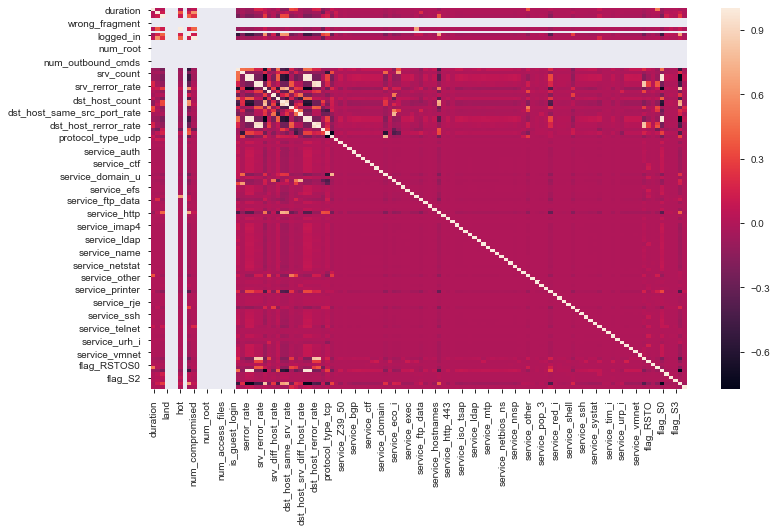

In [64]:
plt.figure(figsize=(12,7))
sns.heatmap(train_data.corr())
plt.show()
#data.corr().to_excel('data_corr.xlsx')

In [65]:
#Removing Independent variables which have a high correlation with other 
#independent variables
train_data.drop(['dst_bytes','logged_in','count',
           'serror_rate','srv_serror_rate','rerror_rate',
           'srv_rerror_rate',
          'same_srv_rate','dst_host_count',
          'dst_host_srv_count','dst_host_same_srv_rate',
          'dst_host_serror_rate','dst_host_srv_serror_rate',
          'dst_host_srv_rerror_rate',
          'protocol_type_tcp','protocol_type_udp','service_http',
          'service_private','flag_S0','flag_SF'],axis=1,inplace=True)

In [66]:
train_data=train_data[list(set(train_data.columns).intersection(set(test_data.columns)))]

In [67]:
train_data.head()

,srv_diff_host_rate,flag_REJ,service_kshell,service_exec,last_flag,service_gopher,flag_RSTR,root_shell,service_iso_tsap,service_nnsp,...,duration,service_ftp_data,service_bgp,service_X11,num_root,service_shell,service_sql_net,service_klogin,is_host_login,service_urp_i
0,0.00,0,0,0,20,0,0,0,0,0,...,0.0,1,0,0,0,0,0,0,0,0
1,0.00,0,0,0,15,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,0,0
2,0.00,0,0,0,19,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,0,0
3,0.00,0,0,0,21,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,0,0
4,0.09,0,0,0,21,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,0,0


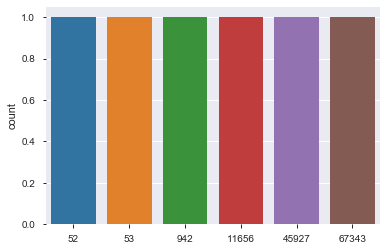

0    67343
1    45927
2    11656
3      942
5       53
4       52
dtype: int64


In [68]:
#Checking for Balanced/Unbalanced Data
sns.countplot(train_attack.value_counts())
plt.show()
print(train_attack.value_counts())

In [69]:
train_data_res,train_attack_res=SMOTE().fit_sample(train_data,train_attack)

In [70]:
test_data=test_data[train_data.columns]

### Multinomial Classification

### Decision Tree

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [35]:
pGrid = {'max_depth': range(25,30),
        'min_samples_split': [2,3,4,5,6]}
gscv_dt = GridSearchCV(estimator=DecisionTreeClassifier(),param_grid=pGrid,cv=5,
                       verbose=10,n_jobs=-1)

In [36]:
gscv_dt.fit(train_data_res,train_attack_res)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  7.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(25, 30),
                         'm

In [37]:
gscv_dt.best_params_

{'max_depth': 26, 'min_samples_split': 2}

In [38]:
tree_clf=DecisionTreeClassifier(max_depth=26,min_samples_split=2).fit(train_data_res,train_attack_res)

In [39]:
train_pred=tree_clf.predict(train_data_res)
test_pred=tree_clf.predict(test_data)

In [40]:
print(metrics.accuracy_score(train_attack_res,train_pred))
print(metrics.accuracy_score(test_attack,test_pred))
#print(metrics.roc_auc_score(train_y_res, train_pred))

0.9998861549579516
0.7707150461320085


In [41]:
train_confusion_matrix=metrics.confusion_matrix(train_attack_res, train_pred)
test_confusion_matrix=metrics.confusion_matrix(test_attack, test_pred)

In [42]:
train_confusion_matrix

array([[67332,     0,     0,    10,     1,     0],
       [    0, 67343,     0,     0,     0,     0],
       [    0,     0, 67343,     0,     0,     0],
       [    0,     0,     0, 67308,    35,     0],
       [    0,     0,     0,     0, 67343,     0],
       [    0,     0,     0,     0,     0, 67343]], dtype=int64)

In [43]:
test_confusion_matrix

array([[9385,   86,  200,   39,    1,    0],
       [1131, 5735,  280,    8,   13,    0],
       [ 727,   58, 1605,   19,   12,    0],
       [ 915,    4,  111,  592,   32,    0],
       [  15,    0,    8,    8,   34,    2],
       [ 831,  473,   21,  104,   71,   24]], dtype=int64)

In [44]:
print(metrics.classification_report(train_attack_res, train_pred))
print(metrics.classification_report(test_attack, test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67343
           1       1.00      1.00      1.00     67343
           2       1.00      1.00      1.00     67343
           3       1.00      1.00      1.00     67343
           4       1.00      1.00      1.00     67343
           5       1.00      1.00      1.00     67343

    accuracy                           1.00    404058
   macro avg       1.00      1.00      1.00    404058
weighted avg       1.00      1.00      1.00    404058

              precision    recall  f1-score   support

           0       0.72      0.97      0.83      9711
           1       0.90      0.80      0.85      7167
           2       0.72      0.66      0.69      2421
           3       0.77      0.36      0.49      1654
           4       0.21      0.51      0.30        67
           5       0.92      0.02      0.03      1524

    accuracy                           0.77     22544
   macro avg       0.71

### Bagging

In [45]:
from sklearn.ensemble import BaggingClassifier

In [58]:
pGrid = {'n_estimators': [150,200,250]}

In [59]:
gscv_bag_cl = GridSearchCV(estimator=BaggingClassifier(),param_grid=pGrid,cv=5,
                       verbose=10,n_jobs=-1)

In [60]:
gscv_bag_cl.fit(train_data_res,train_attack_res)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 34.4min remaining: 17.2min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 39.7min remaining:  9.9min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 51.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
                                         bootstrap_features=False,
                                         max_features=1.0, max_samples=1.0,
                                         n_estimators=10, n_jobs=None,
                                         oob_score=False, random_state=None,
                                         verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': [150, 200, 250]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [61]:
gscv_bag_cl.best_params_

{'n_estimators': 200}

In [62]:
tree_bag_cl=BaggingClassifier(n_estimators=200)
tree_bag_cl.fit(train_data_res,train_attack_res)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=200,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

In [63]:
train_pred=tree_bag_cl.predict(train_data_res)
test_pred=tree_bag_cl.predict(test_data)

In [64]:
print(metrics.accuracy_score(train_attack_res,train_pred))
print(metrics.accuracy_score(test_attack,test_pred))
#print(metrics.roc_auc_score(train_y_res, train_pred))

0.9999901004311262
0.7739088005677786


In [65]:
metrics.confusion_matrix(train_attack_res, train_pred)
metrics.confusion_matrix(test_attack, test_pred)

array([[9382,   86,  230,   12,    1,    0],
       [1043, 5865,  239,    6,   14,    0],
       [ 734,   79, 1590,    7,   11,    0],
       [ 867,    4,  198,  552,   33,    0],
       [  20,    0,    5,    8,   33,    1],
       [ 853,  464,    9,  163,   10,   25]], dtype=int64)

In [66]:
print(metrics.classification_report(train_attack_res, train_pred))
print(metrics.classification_report(test_attack, test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67343
           1       1.00      1.00      1.00     67343
           2       1.00      1.00      1.00     67343
           3       1.00      1.00      1.00     67343
           4       1.00      1.00      1.00     67343
           5       1.00      1.00      1.00     67343

    accuracy                           1.00    404058
   macro avg       1.00      1.00      1.00    404058
weighted avg       1.00      1.00      1.00    404058

              precision    recall  f1-score   support

           0       0.73      0.97      0.83      9711
           1       0.90      0.82      0.86      7167
           2       0.70      0.66      0.68      2421
           3       0.74      0.33      0.46      1654
           4       0.32      0.49      0.39        67
           5       0.96      0.02      0.03      1524

    accuracy                           0.77     22544
   macro avg       0.73

### Random Forest

In [114]:
from sklearn.ensemble import RandomForestClassifier

In [165]:
pGrid = {'n_estimators': [150,200,250,300], 'max_depth': range(20,40)}

In [166]:
gscv_rf_cl = GridSearchCV(estimator=RandomForestClassifier(),param_grid=pGrid,cv=5,
                       verbose=10)

In [167]:
gscv_rf_cl.fit(train_data_res,train_attack_res)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] max_depth=20, n_estimators=200 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... max_depth=20, n_estimators=200, score=0.999, total= 1.3min
[CV] max_depth=20, n_estimators=200 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] ...... max_depth=20, n_estimators=200, score=0.999, total= 1.3min
[CV] max_depth=20, n_estimators=200 ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


[CV] ...... max_depth=20, n_estimators=200, score=0.999, total= 1.3min
[CV] max_depth=20, n_estimators=200 ..................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.9min remaining:    0.0s


[CV] ...... max_depth=20, n_estimators=200, score=1.000, total= 1.3min
[CV] max_depth=20, n_estimators=200 ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.2min remaining:    0.0s


[CV] ...... max_depth=20, n_estimators=200, score=1.000, total= 1.3min
[CV] max_depth=20, n_estimators=250 ..................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.5min remaining:    0.0s


[CV] ...... max_depth=20, n_estimators=250, score=0.999, total= 1.6min
[CV] max_depth=20, n_estimators=250 ..................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.1min remaining:    0.0s


[CV] ...... max_depth=20, n_estimators=250, score=0.999, total= 1.6min
[CV] max_depth=20, n_estimators=250 ..................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  9.7min remaining:    0.0s


[CV] ...... max_depth=20, n_estimators=250, score=0.999, total= 1.7min
[CV] max_depth=20, n_estimators=250 ..................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 11.4min remaining:    0.0s


[CV] ...... max_depth=20, n_estimators=250, score=1.000, total= 1.7min
[CV] max_depth=20, n_estimators=250 ..................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 13.1min remaining:    0.0s


[CV] ...... max_depth=20, n_estimators=250, score=1.000, total= 1.9min
[CV] max_depth=20, n_estimators=300 ..................................
[CV] ...... max_depth=20, n_estimators=300, score=0.999, total= 1.9min
[CV] max_depth=20, n_estimators=300 ..................................
[CV] ...... max_depth=20, n_estimators=300, score=0.999, total= 1.9min
[CV] max_depth=20, n_estimators=300 ..................................
[CV] ...... max_depth=20, n_estimators=300, score=0.999, total= 2.0min
[CV] max_depth=20, n_estimators=300 ..................................
[CV] ...... max_depth=20, n_estimators=300, score=1.000, total= 1.8min
[CV] max_depth=20, n_estimators=300 ..................................
[CV] ...... max_depth=20, n_estimators=300, score=1.000, total= 1.9min
[CV] max_depth=21, n_estimators=200 ..................................
[CV] ...... max_depth=21, n_estimators=200, score=0.999, total= 1.2min
[CV] max_depth=21, n_estimators=200 ..................................
[CV] .

[CV] ...... max_depth=24, n_estimators=250, score=1.000, total= 2.5min
[CV] max_depth=24, n_estimators=250 ..................................
[CV] ...... max_depth=24, n_estimators=250, score=1.000, total= 2.5min
[CV] max_depth=24, n_estimators=250 ..................................
[CV] ...... max_depth=24, n_estimators=250, score=1.000, total= 2.5min
[CV] max_depth=24, n_estimators=300 ..................................
[CV] ...... max_depth=24, n_estimators=300, score=1.000, total= 2.8min
[CV] max_depth=24, n_estimators=300 ..................................
[CV] ...... max_depth=24, n_estimators=300, score=0.999, total= 3.0min
[CV] max_depth=24, n_estimators=300 ..................................
[CV] ...... max_depth=24, n_estimators=300, score=1.000, total= 3.0min
[CV] max_depth=24, n_estimators=300 ..................................
[CV] ...... max_depth=24, n_estimators=300, score=1.000, total= 3.0min
[CV] max_depth=24, n_estimators=300 ..................................
[CV] .

[CV] ...... max_depth=28, n_estimators=250, score=0.999, total= 1.5min
[CV] max_depth=28, n_estimators=250 ..................................
[CV] ...... max_depth=28, n_estimators=250, score=0.999, total= 1.6min
[CV] max_depth=28, n_estimators=250 ..................................
[CV] ...... max_depth=28, n_estimators=250, score=1.000, total= 1.7min
[CV] max_depth=28, n_estimators=250 ..................................
[CV] ...... max_depth=28, n_estimators=250, score=1.000, total= 1.7min
[CV] max_depth=28, n_estimators=250 ..................................
[CV] ...... max_depth=28, n_estimators=250, score=1.000, total= 1.8min
[CV] max_depth=28, n_estimators=300 ..................................
[CV] ...... max_depth=28, n_estimators=300, score=0.999, total= 2.1min
[CV] max_depth=28, n_estimators=300 ..................................
[CV] ...... max_depth=28, n_estimators=300, score=1.000, total= 2.4min
[CV] max_depth=28, n_estimators=300 ..................................
[CV] .

[CV] ...... max_depth=32, n_estimators=200, score=1.000, total= 1.3min
[CV] max_depth=32, n_estimators=200 ..................................
[CV] ...... max_depth=32, n_estimators=200, score=1.000, total= 1.3min
[CV] max_depth=32, n_estimators=250 ..................................
[CV] ...... max_depth=32, n_estimators=250, score=0.999, total= 1.5min
[CV] max_depth=32, n_estimators=250 ..................................
[CV] ...... max_depth=32, n_estimators=250, score=0.999, total= 1.6min
[CV] max_depth=32, n_estimators=250 ..................................
[CV] ...... max_depth=32, n_estimators=250, score=1.000, total= 1.5min
[CV] max_depth=32, n_estimators=250 ..................................
[CV] ...... max_depth=32, n_estimators=250, score=1.000, total= 1.5min
[CV] max_depth=32, n_estimators=250 ..................................
[CV] ...... max_depth=32, n_estimators=250, score=1.000, total= 1.6min
[CV] max_depth=32, n_estimators=300 ..................................
[CV] .

[CV] ...... max_depth=36, n_estimators=200, score=1.000, total= 1.3min
[CV] max_depth=36, n_estimators=200 ..................................
[CV] ...... max_depth=36, n_estimators=200, score=0.999, total= 1.2min
[CV] max_depth=36, n_estimators=200 ..................................
[CV] ...... max_depth=36, n_estimators=200, score=1.000, total= 1.2min
[CV] max_depth=36, n_estimators=200 ..................................
[CV] ...... max_depth=36, n_estimators=200, score=1.000, total= 1.2min
[CV] max_depth=36, n_estimators=250 ..................................
[CV] ...... max_depth=36, n_estimators=250, score=0.999, total= 1.5min
[CV] max_depth=36, n_estimators=250 ..................................
[CV] ...... max_depth=36, n_estimators=250, score=0.999, total= 1.5min
[CV] max_depth=36, n_estimators=250 ..................................
[CV] ...... max_depth=36, n_estimators=250, score=1.000, total= 1.5min
[CV] max_depth=36, n_estimators=250 ..................................
[CV] .

[CV] ...... max_depth=39, n_estimators=300, score=1.000, total= 2.0min


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 535.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [168]:
gscv_rf_cl.best_params_

{'max_depth': 27, 'n_estimators': 200}

In [169]:
rf_cl=RandomForestClassifier(n_estimators=200,max_depth=27)
rf_cl.fit(train_data_res,train_attack_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=27, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [170]:
train_pred=rf_cl.predict(train_data_res)
test_pred=rf_cl.predict(test_data)

In [171]:
print(metrics.accuracy_score(train_attack_res,train_pred))
print(metrics.accuracy_score(test_attack,test_pred))
#print(metrics.roc_auc_score(train_y_res, train_pred))

0.9998812051735146
0.7771469127040455


In [172]:
metrics.confusion_matrix(train_attack_res, train_pred)
metrics.confusion_matrix(test_attack, test_pred)

array([[9414,   76,  219,    2,    0,    0],
       [1221, 5835,  110,    0,    1,    0],
       [ 537,   90, 1794,    0,    0,    0],
       [1011,    0,  183,  446,   14,    0],
       [  18,    0,    0,   18,   31,    0],
       [1227,    0,  183,   92,   22,    0]], dtype=int64)

In [173]:
print(metrics.classification_report(train_attack_res, train_pred))
print(metrics.classification_report(test_attack, test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67343
           1       1.00      1.00      1.00     67343
           2       1.00      1.00      1.00     67343
           3       1.00      1.00      1.00     67343
           4       1.00      1.00      1.00     67343
           5       1.00      1.00      1.00     67343

    accuracy                           1.00    404058
   macro avg       1.00      1.00      1.00    404058
weighted avg       1.00      1.00      1.00    404058

              precision    recall  f1-score   support

           0       0.70      0.97      0.81      9711
           1       0.97      0.81      0.89      7167
           2       0.72      0.74      0.73      2421
           3       0.80      0.27      0.40      1654
           4       0.46      0.46      0.46        67
           5       0.00      0.00      0.00      1524

    accuracy                           0.78     22544
   macro avg       0.61

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Naive Bayes

In [71]:
from sklearn.naive_bayes import GaussianNB

In [72]:
gnb=GaussianNB()
gnb.fit(train_data_res,train_attack_res)

GaussianNB(priors=None, var_smoothing=1e-09)

In [75]:
train_pred=gnb.predict(train_data_res)
test_pred=gnb.predict(test_data)

In [76]:
print(metrics.accuracy_score(train_attack_res,train_pred))
print(metrics.accuracy_score(test_attack,test_pred))
#print(metrics.roc_auc_score(train_y_res, train_pred))

0.7392329814036599
0.480083392476934


In [77]:
metrics.confusion_matrix(train_attack_res, train_pred)
metrics.confusion_matrix(test_attack, test_pred)

array([[1575, 7679,  300,  140,   17,    0],
       [  19, 5780,  495,  870,    3,    0],
       [  22,  250, 2113,   10,   26,    0],
       [   1,  292,  293, 1010,   58,    0],
       [   0,    0,    5,   44,   17,    1],
       [ 409,   23,  188,  304,  272,  328]], dtype=int64)

In [78]:
print(metrics.classification_report(train_attack_res, train_pred))
print(metrics.classification_report(test_attack, test_pred))

              precision    recall  f1-score   support

           0       0.96      0.24      0.39     67343
           1       0.56      0.97      0.71     67343
           2       0.94      0.85      0.89     67343
           3       0.82      0.42      0.55     67343
           4       0.61      0.98      0.75     67343
           5       1.00      0.98      0.99     67343

    accuracy                           0.74    404058
   macro avg       0.81      0.74      0.71    404058
weighted avg       0.81      0.74      0.71    404058

              precision    recall  f1-score   support

           0       0.78      0.16      0.27      9711
           1       0.41      0.81      0.55      7167
           2       0.62      0.87      0.73      2421
           3       0.42      0.61      0.50      1654
           4       0.04      0.25      0.07        67
           5       1.00      0.22      0.35      1524

    accuracy                           0.48     22544
   macro avg       0.55